# Baseline Model Experiment 

This notebook contains a baseline model experiment with a simple Artificial Neural Network (ANN) using [FastAI Tabular Learner](https://docs.fast.ai/tabular.learner.html). We begin experiments with this simple model on the premise that - when taking into account the level of effort - clever feature engineering typically outperforms employing alternative model types (such as using LSTMs). 

A few items about the experiment: 

- We train for `D` days (periods) and predict on the next day in order to train the model. After each complete period, the model is retrained on the new data (either from scratch or with transfter learning). We model the experiment this way to coincide with how a model would be used in practice and to account for the fast that the most recent data has an outsized influence on model performance. 
- We identify and utilize periods of observations for model training and testing that are greater than some threshold `period_size`. Deep neural networks cannot be trained with missing data. 
- Related to the above, it would be an inappropriate training strategy to simply concatenate the periods together during the training process - the value(s) at the end of a period does not help predict the values at the beginning of the next period. As such, we will need to retrain the model for each subsequent day in the training set using transfer learning. The same testing set is used throughout the model training process. 
- An appropriate learning rate is determined using an automated learning rate finder. 
- The model is trained using an early stopping criterion that is intened to ovoid model overfitting. 
- A selection of possible model architectures for the ANN (nodes in the layers, drop out rates, etc). is available for the experiments. 

## Imports 

In [1]:
import sys; sys.executable

'/home/vconstan/.conda/envs/tsunami/bin/python'

In [2]:
from fastai.tabular import *
from fastai.metrics import *
from fastai import torch_core
from fastai.callbacks import *
from fastai.callbacks.mem import PeakMemMetric
from fastai.utils.mod_display import *

import pandas as pd
from pathlib import Path
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
import seaborn as sns
from scipy import spatial, stats
from src import data
import time
import torch
from tqdm.notebook import tqdm

## Define Experiment Recorder

We'll create a dictionary here that we can use to keep track of information and objects related to the experiment. This information can then be pickled and exported to disk for later retrieval and examination (e.g., pulling up previous result sets).

In [3]:
# define the exeriment recorder - everything is None on initialization 

recorder = {
    "experiment": None,
    "total_time_elapsed": None,
    "training_time_elapsed": None,
    "validation_time_elapsed": None,
    "model": None,
    "batch_size": None,
    "max_epocs": None,
    "year": None,
    "location": None,
    "days": None,
    "ground_station": None,
    "satellite": None,
    "ele_filter": None,
    "time_agg": None,
    "batch_norm": None,
    "weight_decay": None,
    "dependent": None,
    "features": None,
    "model_name": None,
    "model_path": None,
    "mean_gpu_mem": None,
    "mean_gpu_compute": None,
    "root_mean_square_error": None, # at end of run,
    "validation_loss": None,
    "training_loss": None,
    "precision": None,
    "recall": None,
    "f_score": None,
    "accuracy": None, 
    "coverage": None
}

## Experiment Parameters

In [4]:
architectures = {
    1: {
        "layers": [10, 500, 1000, 2500, 25000, 2500, 1000, 500, 10],
        "ps": [0.0, 0.1, 0.2, 0.2, 0.25, 0.2, 0.2, 0.1, 0.0]
    },
    2: {
        "layers": [10, 50, 100, 250, 1000, 250, 100, 50, 10],
        "ps": [0.5, 0.4, 0.3, 0.2, 0.2, 0.1, 0.05, 0.025, 0.0]
    },
    3: {
        "layers": [10, 50, 100, 250, 1000, 250, 100, 50, 10],
        "ps": [0.0, 0.025, 0.05, 0.1, 0.2, 0.2, 0.3, 0.4, 0.5]
    },
    4: {
        "layers": [50000, 5000, 1000, 500, 25, 1],
        "ps": [0.2, 0.15, 0.1, 0.05, 0.025, 0.]
    },
    5: {
        "layers": [50000, 7500, 2500, 1000, 250, 80, 25, 1],
        "ps": [0.25, 0.2, 0.15, 0.1, 0.05, 0.025, 0.01, 0]
    }
}

In [5]:
# data 
YEAR = 2012 # can be 2012, 2015
LOCATION = "hawaii" # can be hawaii, chile
DATA_PATHS = Path('../data/' + LOCATION + '/' + str(YEAR))
DAYS = [str(f).split("/")[-1] for f in DATA_PATHS.iterdir() if f.is_dir()]
GROUND_STATION = "ahup" # string
SAT = "G07" # string
ELE_FILTER = 15 # int or None
TIME_AGG = "1Min"
BATCH_NORM = True
WEIGHT_DECAY = 0.1

# model specification 
MODEL_SAVE_DIR = ""
MODEL_NAME = "model-latest"
if MODEL_SAVE_DIR == "":
    MODEL_LOCATION = MODEL_NAME
else:
    MODEL_LOCATION = MODEL_SAVE_DIR + "/" + MODEL_NAME
MODEL_ARCHITECTURE = 5
BATCH_SIZE = 16
DEP = GROUND_STATION + "__" + SAT
FEATURES = [
#     GROUND_STATION + "__" + SAT,
    GROUND_STATION + "__" + SAT + "_ele",
    GROUND_STATION + "__" + SAT + "_lat",
    GROUND_STATION + "__" + SAT + "_lon",
    GROUND_STATION + "__" + SAT + "_h_ipp"
]
MAX_EPOCHS = 500

## Select a CUDA Device

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.cuda.device_count()

4

In [8]:
DEVICE = 3

In [9]:
torch.cuda.set_device(DEVICE)

In [10]:
cuda_device = torch.device('cuda:' + str(DEVICE))

In [11]:
torch.cuda.current_device()

3

One useful command for monitoring GPU utilization is one from `nvidia-smi`:

```bash
nvidia-smi -q -g 0 -d UTILIZATION -l
```

Or: 

```bash
gpustat -cp -i 1
```

## Read Data

This experiment uses data from the Hawaii dataset. We will train the model on a period of `D` days (periods) and test on the latest day (period). The day of the earthquake will represent the _validation_ set, data that is unseen during the model training process. 

In [12]:
dataframes = dict()
for d in DAYS:
    print("\n--- " + str(d) + "---")
    
    # read in the data 
    df = data.read_day(
        location=LOCATION,
        year=YEAR,
        day_of_year=int(d)
    )
    dataframes[d] = df

  0%|          | 4/1595 [00:00<00:43, 36.77it/s]


--- 300---
Reading dataframes...


100%|██████████| 1595/1595 [00:45<00:00, 35.05it/s]


Concatenating dataframes...


  0%|          | 4/1596 [00:00<00:42, 37.22it/s]


--- 301---
Reading dataframes...


100%|██████████| 1596/1596 [00:44<00:00, 35.69it/s]


Concatenating dataframes...


  0%|          | 4/1597 [00:00<00:42, 37.79it/s]


--- 302---
Reading dataframes...


100%|██████████| 1597/1597 [00:45<00:00, 35.05it/s]


Concatenating dataframes...


  0%|          | 4/1597 [00:00<00:43, 36.82it/s]


--- 303---
Reading dataframes...


100%|██████████| 1597/1597 [00:46<00:00, 34.70it/s]


Concatenating dataframes...


  0%|          | 4/1596 [00:00<00:43, 36.35it/s]


--- 304---
Reading dataframes...


100%|██████████| 1596/1596 [00:45<00:00, 34.77it/s]


Concatenating dataframes...


  0%|          | 4/1656 [00:00<00:44, 37.10it/s]


--- 290---
Reading dataframes...


100%|██████████| 1656/1656 [00:46<00:00, 35.69it/s]


Concatenating dataframes...


  0%|          | 4/1654 [00:00<00:43, 38.03it/s]


--- 291---
Reading dataframes...


100%|██████████| 1654/1654 [00:45<00:00, 36.43it/s]


Concatenating dataframes...


  0%|          | 4/1646 [00:00<00:42, 38.48it/s]


--- 292---
Reading dataframes...


100%|██████████| 1646/1646 [00:44<00:00, 36.71it/s]


Concatenating dataframes...


  0%|          | 4/1649 [00:00<00:43, 37.97it/s]


--- 293---
Reading dataframes...


100%|██████████| 1649/1649 [00:45<00:00, 36.59it/s]


Concatenating dataframes...


  0%|          | 4/1655 [00:00<00:43, 38.07it/s]


--- 294---
Reading dataframes...


100%|██████████| 1655/1655 [00:44<00:00, 36.91it/s]


Concatenating dataframes...


  0%|          | 4/1648 [00:00<00:44, 37.08it/s]


--- 295---
Reading dataframes...


100%|██████████| 1648/1648 [00:45<00:00, 36.18it/s]


Concatenating dataframes...


  0%|          | 4/1655 [00:00<00:46, 35.77it/s]


--- 296---
Reading dataframes...


100%|██████████| 1655/1655 [00:45<00:00, 36.26it/s]


Concatenating dataframes...


  0%|          | 4/1647 [00:00<00:43, 37.55it/s]


--- 297---
Reading dataframes...


100%|██████████| 1647/1647 [00:45<00:00, 36.59it/s]


Concatenating dataframes...


  0%|          | 4/1657 [00:00<00:44, 37.02it/s]


--- 298---
Reading dataframes...


100%|██████████| 1657/1657 [00:44<00:00, 36.84it/s]


Concatenating dataframes...


  0%|          | 4/1656 [00:00<00:42, 38.94it/s]


--- 299---
Reading dataframes...


100%|██████████| 1656/1656 [00:44<00:00, 36.85it/s]


Concatenating dataframes...


In [13]:
# concatenate the dataframes loaded previously into one large dataframe 
df_all = pd.concat([dataframes[d] for d in dataframes.keys()]) 

## Prep Dataset

The above experimental parameter definitions will be interesting to explore. However, we also need to be smart about which data we feed into the model for training and how to feet that data into the model as well in order to set a good baseline for our experiments. 

The data contains missing values and - in practice and in the real-world - and we'll need to account for that in our modeling strategy. We'll want to train the model on each chunk of data to come in, and a chunk represents a continuous stretch of data without any missing values. 

In [14]:
df_sat = df_all.filter(regex=GROUND_STATION + "__" + SAT, axis=1)

In [15]:
df_sat.head()

ahup__G07  ahup__G07_lon  ahup__G07_lat  ahup__G07_h_ipp  \
timestamp                                                                       
2012-10-26 00:00:15        NaN            NaN            NaN              NaN   
2012-10-26 00:00:30        NaN            NaN            NaN              NaN   
2012-10-26 00:00:45        NaN            NaN            NaN              NaN   
2012-10-26 00:01:00        NaN            NaN            NaN              NaN   
2012-10-26 00:01:15        NaN            NaN            NaN              NaN   

                     ahup__G07_ele  ahup__G07_azi  
timestamp                                          
2012-10-26 00:00:15            NaN            NaN  
2012-10-26 00:00:30            NaN            NaN  
2012-10-26 00:00:45            NaN            NaN  
2012-10-26 00:01:00            NaN            NaN  
2012-10-26 00:01:15            NaN            NaN

In [16]:
df_sat.shape

(86409, 6)

### Elevation Filter 

Exclude any observations recorded below a specific elevation specified. 

In [17]:
if ELE_FILTER is not None: 
    df_sat = df_sat[df_sat[GROUND_STATION + "__" + SAT + "_ele"] > ELE_FILTER]

In [18]:
df_sat.shape

(9237, 6)

### Resample

In [19]:
df_model = df_sat.dropna().resample(TIME_AGG).mean()

In [20]:
df_model

ahup__G07  ahup__G07_lon  ahup__G07_lat  ahup__G07_h_ipp  \
timestamp                                                                       
2012-10-16 07:26:00  -0.017716    -156.813049      14.158098    350013.899483   
2012-10-16 07:27:00  -0.018477    -156.796491      14.221405    350034.036953   
2012-10-16 07:28:00  -0.016975    -156.774644      14.305501    349984.315694   
2012-10-16 07:29:00  -0.015315    -156.753598      14.387391    349987.334470   
2012-10-16 07:30:00  -0.014461    -156.733166      14.467702    349997.927205   
...                        ...            ...            ...              ...   
2012-10-30 11:53:00   0.000226    -148.174821      24.557565    349997.952327   
2012-10-30 11:54:00   0.001183    -148.068057      24.562147    350002.483540   
2012-10-30 11:55:00   0.002884    -147.960100      24.566026    350012.870488   
2012-10-30 11:56:00   0.000835    -147.851625      24.568775    349994.710813   
2012-10-30 11:57:00   0.000364    -147.769621      24.570329    349981.174342   

                     ahup__G07_ele  ahup__G07_azi  
timestamp                                          
2012-10-16 07:26:00      26.737046     196.155918  
2012-10-16 07:27:00      27.069571     196.173014  
2012-10-16 07:28:00      27.513937     196.198020  
2012-10-16 07:29:00      27.959498     196.225696  
2012-10-16 07:30:00      28.406224     196.256074  
...                            ...            ...  
2012-10-30 11:53:00      15.842818      50.650434  
2012-10-30 11:54:00      15.625204      51.021092  
2012-10-30 11:55:00      15.408621      51.392433  
2012-10-30 11:56:00      15.193260      51.764273  
2012-10-30 11:57:00      15.032450      52.043506  

[20432 rows x 6 columns]

### Visualize Available Data

#### All Base Features for The Satellite and Ground Station

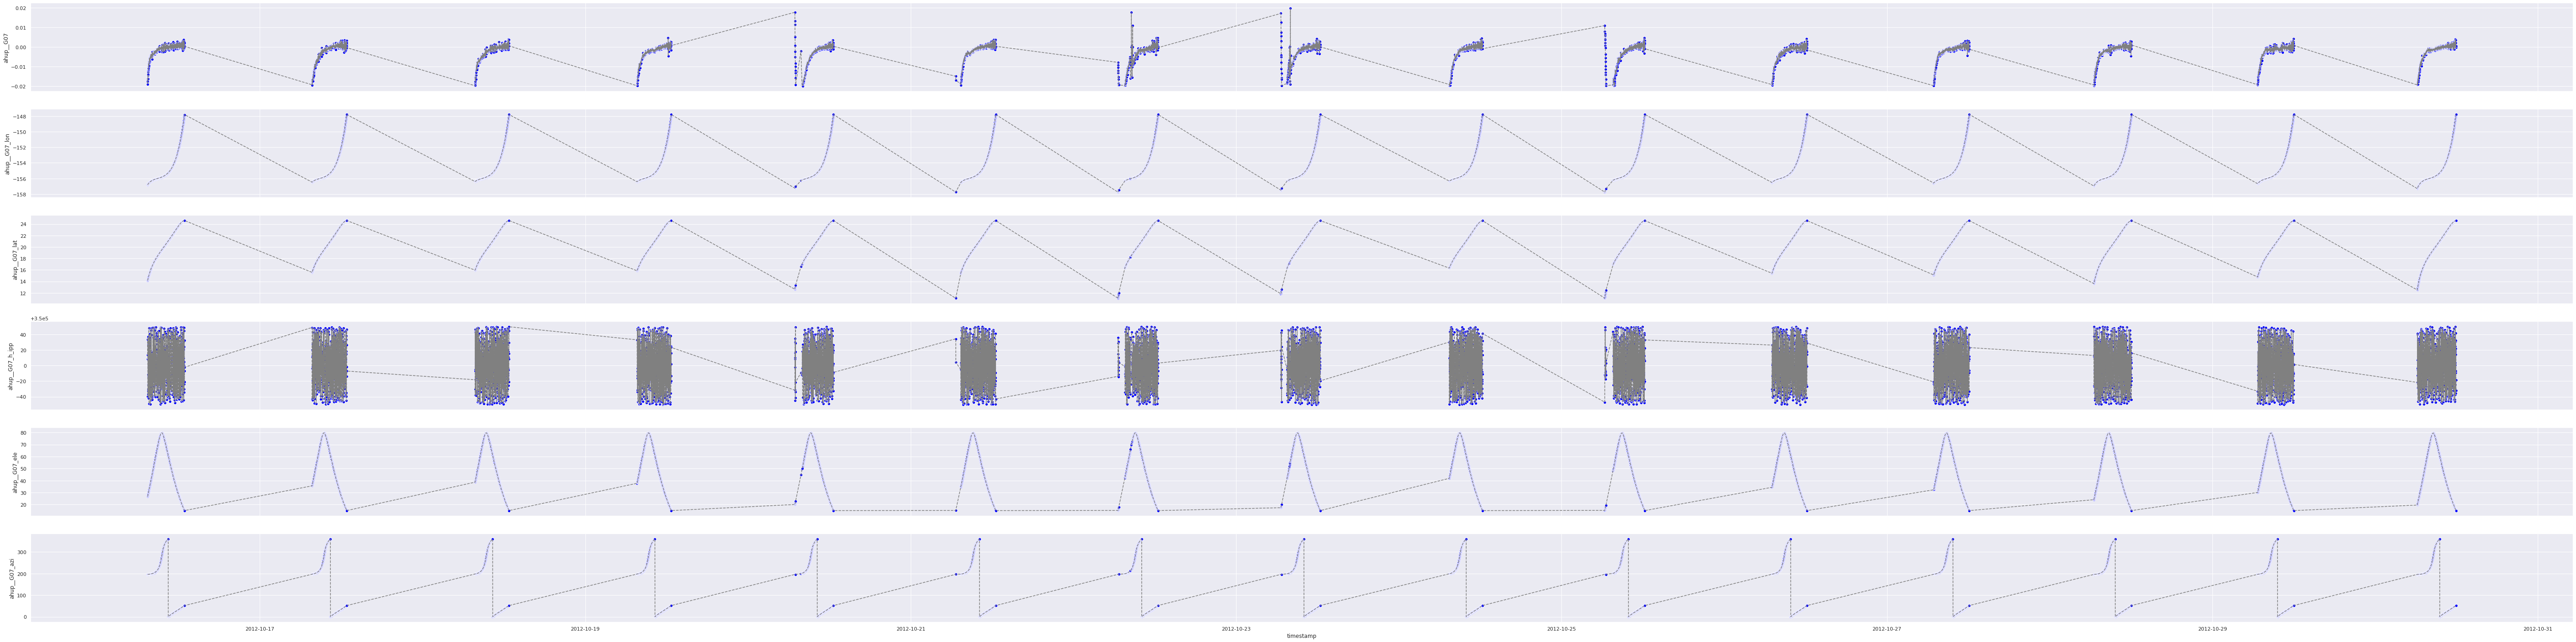

In [21]:
# create subplots that show the values in the data
values = list()
for val in df_sat:
    values.append(val)


sns.set(style="darkgrid")
f, axes = plt.subplots(len(values), 1, figsize=(100,25), sharex=True)
i = 0

for val in values:
    ax = sns.lineplot(x=df_sat.index, y=val, ax=axes[i], data=df_sat, color="gray")
    ax.lines[0].set_linestyle("--")
    
    ax2 = sns.scatterplot(x=df_sat.index, y=val,
                data=df_sat, ax=axes[i],
                color="blue")
    
    i += 1


plt.show()

#### For the Day of the Earthquake 

In [22]:
# get those dates from the 28th of the month, day of the earthquake
filter_index = df_sat.index.to_series().between('2012-10-28', '2012-10-28 23:59:00')

In [23]:
df_sat_earthquake = df_sat[filter_index]

In [24]:
df_sat_earthquake

ahup__G07  ahup__G07_lon  ahup__G07_lat  ahup__G07_h_ipp  \
timestamp                                                                       
2012-10-28 06:32:00  -0.019450    -156.973207      13.619071    350012.920879   
2012-10-28 06:33:00  -0.019724    -156.946673      13.714556    349973.613494   
2012-10-28 06:33:30  -0.019198    -156.934091      13.760236    350049.720779   
2012-10-28 06:34:00  -0.019344    -156.921219      13.807090    350011.441013   
2012-10-28 06:34:30  -0.019037    -156.908802      13.852573    350037.782811   
...                        ...            ...            ...              ...   
2012-10-28 12:03:00   0.000202    -147.992023      24.568992    349996.368164   
2012-10-28 12:03:30   0.000311    -147.938554      24.570279    349956.218126   
2012-10-28 12:04:00   0.002643    -147.883694      24.572128    349984.440305   
2012-10-28 12:04:30  -0.000874    -147.828679      24.573682    350003.450966   
2012-10-28 12:05:00   0.000931    -147.773545      24.574951    350016.265963   

                     ahup__G07_ele  ahup__G07_azi  
timestamp                                          
2012-10-28 06:32:00      24.103139     196.202074  
2012-10-28 06:33:00      24.539428     196.210849  
2012-10-28 06:33:30      24.757891     196.216266  
2012-10-28 06:34:00      24.976802     196.222260  
2012-10-28 06:34:30      25.195880     196.228965  
...                            ...            ...  
2012-10-28 12:03:00      15.465331      51.261226  
2012-10-28 12:03:30      15.357260      51.446952  
2012-10-28 12:04:00      15.249563      51.632742  
2012-10-28 12:04:30      15.142039      51.818775  
2012-10-28 12:05:00      15.034886      52.004870  

[666 rows x 6 columns]

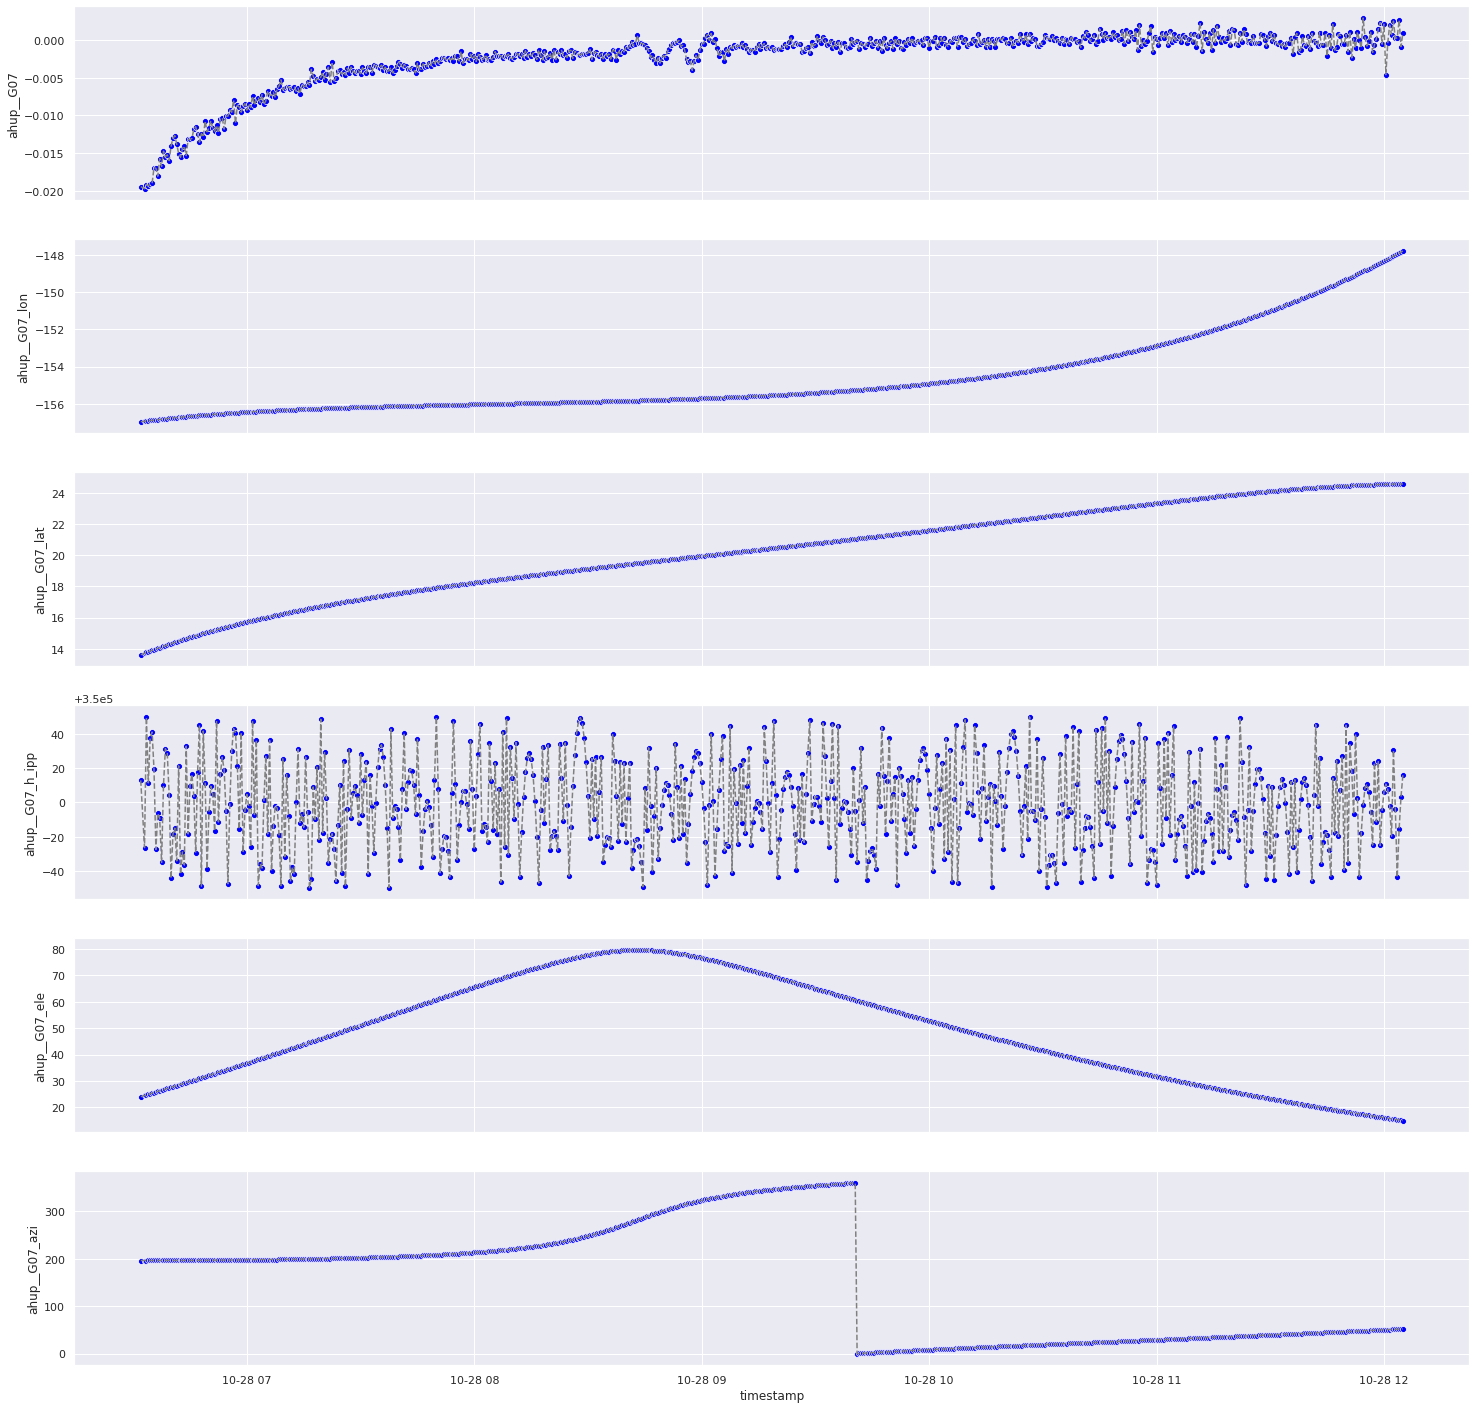

In [25]:
# create subplots similar to the paper
values = list()
for val in df_sat_earthquake:
    values.append(val)


sns.set(style="darkgrid")
f, axes = plt.subplots(len(values), 1, figsize=(25,25), sharex=True)
i = 0

for val in values:
    ax = sns.lineplot(x=df_sat_earthquake.index, y=val, ax=axes[i], data=df_sat_earthquake, color="gray")
    ax.lines[0].set_linestyle("--")
    
    ax2 = sns.scatterplot(x=df_sat_earthquake.index, y=val,
                data=df_sat_earthquake, ax=axes[i],
                color="blue")
    
    i += 1


plt.show()

### Split The Data Into Periods 

These periods are defined by consecutive empty (NaN) values in the dataframe. The data is only available for the satellite as it passes close to the ground station on each day. We will train the data in a similar way, ensuring our approach is compatible with the constraints in the operating environment. 

In [26]:
def split_dataframe(dataframe: pd.DataFrame) -> list: 

    # handle missing values and "chunk" the data for training and testing 
    events = np.split(dataframe, np.where(np.isnan(dataframe))[0])

    # removing NaN entries
    events = [ev[~np.isnan(ev)] for ev in events if not isinstance(ev, np.ndarray)]

    # removing empty DataFrames
    events = [ev.dropna() for ev in events if not ev.empty and ev.shape[0] > 100]

    return events

In [27]:
events = split_dataframe(df_model)
len(events)

15

In [28]:
events[1]

ahup__G07  ahup__G07_lon  ahup__G07_lat  ahup__G07_h_ipp  \
timestamp                                                                       
2012-10-17 07:42:00  -0.019215    -156.472692      15.584837    350030.140157   
2012-10-17 07:43:00  -0.018256    -156.459662      15.645805    349976.305788   
2012-10-17 07:44:00  -0.018670    -156.447263      15.704889    350023.792245   
2012-10-17 07:45:00  -0.017469    -156.435001      15.763688    350006.962532   
2012-10-17 07:46:00  -0.016726    -156.423027      15.821687    349983.861231   
...                        ...            ...            ...              ...   
2012-10-17 12:45:00   0.000098    -148.203893      24.579709    349984.743524   
2012-10-17 12:46:00  -0.000057    -148.097179      24.584916    349976.068691   
2012-10-17 12:47:00   0.002287    -147.988653      24.589854    350012.324647   
2012-10-17 12:48:00   0.001233    -147.879556      24.593650    350016.303941   
2012-10-17 12:49:00  -0.000410    -147.797575      24.595681    349992.911237   

                     ahup__G07_ele  ahup__G07_azi  
timestamp                                          
2012-10-17 07:42:00      35.723193     197.150723  
2012-10-17 07:43:00      36.187937     197.231851  
2012-10-17 07:44:00      36.653770     197.316228  
2012-10-17 07:45:00      37.120376     197.404039  
2012-10-17 07:46:00      37.587986     197.495222  
...                            ...            ...  
2012-10-17 12:45:00      15.863726      50.419763  
2012-10-17 12:46:00      15.644894      50.789424  
2012-10-17 12:47:00      15.427240      51.159654  
2012-10-17 12:48:00      15.210595      51.530592  
2012-10-17 12:49:00      15.048942      51.809054  

[308 rows x 6 columns]

We know from domain knowledge that each period in the data corresponds to a specific day. The third day in the dataset (`302`) corresponds to the third period (index `2`) in the dataset. 

All of the experiments will attempt at detecting the anomaly using an analysis of the residual values using the day of the earthquake, which will be contained in the `validation` set. Data prior to the day of the earthquake, with the day prior to the earthquake being used for `test` data. Any days prior to that are considered as training data. 

At some point in the future, we will want to setup a controlled trail of how this would operate in practice (daily retraining of models). For now, we will focus on the task of training the model for the first time. 

### Scale the Data 

Deep learning models do not perform well when model inputs are not scaled appropriately. In this application, we will scale the data for each feature to a scale of -1 to 1, and do so separetely for each day. This is again driven by operational considerations. 

In [29]:
normalized_events = list()
for ev in events: 
    
    # for each column in the data, rescale -1 to 1 
    col_data = list()
    for col in ev.columns.values:
        
        normalized_data = minmax_scale(
                    ev[col].dropna(), 
                    feature_range=(-1, 1)
                )
        col_data.append(normalized_data)
        
    df_period = pd.DataFrame(np.array(col_data).T, columns=list(ev.columns.values) )
    df_period["timestamp"] = ev[col].index
    df_period.index = df_period["timestamp"]
    df_period = df_period.drop(columns=["timestamp"])
    
    # convert to seconds of the day for later annotation 
    df_period["sod"] = (df_period.index.hour*60+df_period.index.minute)*60 + df_period.index.second
    
    normalized_events.append(df_period)


In [30]:
len(normalized_events)

15

In [31]:
normalized_events[13].shape

(321, 7)

In [32]:
normalized_events[12]

ahup__G07  ahup__G07_lon  ahup__G07_lat  ahup__G07_h_ipp  \
timestamp                                                                       
2012-10-28 06:32:00  -0.998949      -1.000000      -1.000000         0.230965   
2012-10-28 06:33:00  -1.000000      -0.992864      -0.978400         0.203362   
2012-10-28 06:34:00  -0.974355      -0.987348      -0.961526         0.488362   
2012-10-28 06:35:00  -0.858453      -0.981980      -0.944953         0.611693   
2012-10-28 06:36:00  -0.817479      -0.976721      -0.928568        -0.426113   
...                        ...            ...            ...              ...   
2012-10-28 12:01:00   0.922159       0.911776       0.997527         0.005077   
2012-10-28 12:02:00   1.000000       0.934984       0.998381         0.065603   
2012-10-28 12:03:00   0.871633       0.958315       0.999030        -0.575455   
2012-10-28 12:04:00   0.931232       0.982034       0.999627        -0.186807   
2012-10-28 12:05:00   0.935626       1.000000       1.000000         0.304612   

                     ahup__G07_ele  ahup__G07_azi    sod  
timestamp                                                 
2012-10-28 06:32:00      -0.718884       0.090543  23520  
2012-10-28 06:33:00      -0.701972       0.090607  23580  
2012-10-28 06:34:00      -0.688404       0.090674  23640  
2012-10-28 06:35:00      -0.674795       0.090755  23700  
2012-10-28 06:36:00      -0.661150       0.090851  23760  
...                            ...            ...    ...  
2012-10-28 12:01:00      -0.974860      -0.719393  43260  
2012-10-28 12:02:00      -0.981611      -0.717332  43320  
2012-10-28 12:03:00      -0.988331      -0.715267  43380  
2012-10-28 12:04:00      -0.995012      -0.713199  43440  
2012-10-28 12:05:00      -1.000000      -0.711647  43500  

[334 rows x 7 columns]

### Allocate Data for Modeling

In [33]:
def allocate_periods(periods: list, index_earthquake: int) -> dict:
    
    data = dict()
    
    data["valid"] = periods[index_earthquake]
    data["test"] = periods[index_earthquake - 1]
    data["train"] = periods[0:index_earthquake - 1]
    
    return data

In [34]:
df_model_by_period = allocate_periods(normalized_events, 12)

## Train the Model 

In [35]:
print(len(df_model_by_period["train"]))

11


The below function preps the data for modeling in Fast AI. 

In [36]:
## Work in progress
def make_dataBunch(df_train: pd.DataFrame, df_test: pd.DataFrame, df_valid: pd.DataFrame, features: list, dependent: str, include_catvars: bool = False, catvars: list = [], batch_size: int = 256):
    """
    Creates a TabularDataBunch to feed as an input 
    into the learner. 
    """
    
    valid_start_index = df_train.shape[0] + 1
    valid_end_index = df_train.shape[0] + df_test.shape[0]
    
    df_train_validation = pd.concat([df_train, df_test])
        
    # create the data bunch
    if include_catvars:
        data = TabularDataBunch.from_df(
            "models", 
            df_train_validation[features + [dependent]], 
            dependent, 
            valid_idx=np.array(list(range(valid_start_index, valid_end_index))),
#             test_df=df_test, 
            procs=[Categorify],
            bs=batch_size, # batch size
            cat_names=catvars,
            device=cuda_device,
            num_workers=0
        )
    else:
        data = TabularDataBunch.from_df(
            "models", 
            df_train_validation[features + [dependent]], 
            dependent, 
            valid_idx=np.array(list(range(valid_start_index, valid_end_index))),
#             test_df=df_test, 
            procs=None, # disable any automatic preprocessing
            bs=batch_size, # batch size
            device=cuda_device,
            num_workers=0
        )
 
    return {
        "databunch": data, 
        "train": df_train, 
        "test": df_test, 
        "valid": df_valid
    }

### Determine the Learning Rate

We utilize an [automatic learning rate finder](https://forums.fast.ai/t/automated-learning-rate-suggester/44199/8) to determine the ideal learning rate automatically. While this approach does not always guarantee that the perfect learning rate is found, in practice we have found the approach to work well and has been quite stable.

In [37]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find(
        end_lr=2.,
        stop_div=False # continues through all LRs as opposed to auto stopping
    )
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

We will train the model for each day in the training set. 

### Time Series Cross Validation

Time-Series CV results will be tracked. Will contain the following: 

- `root_mean_square_error`
- `period`
- `learn_rate` 
- `training_time_seconds`

Learning rate: 0.001


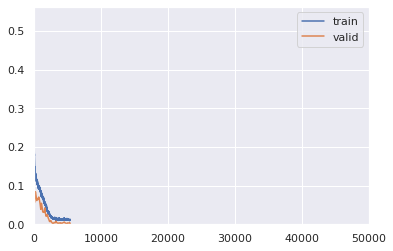

Epoch 53: early stopping
Results from last tra ining set.


None


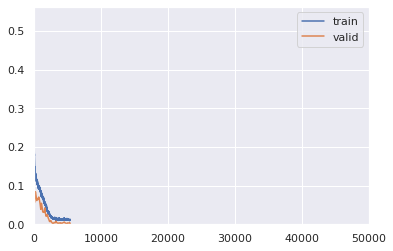

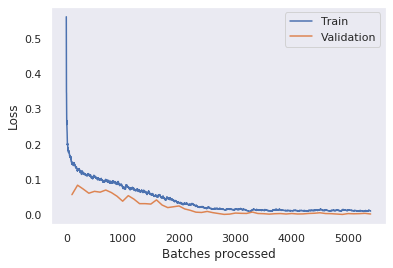

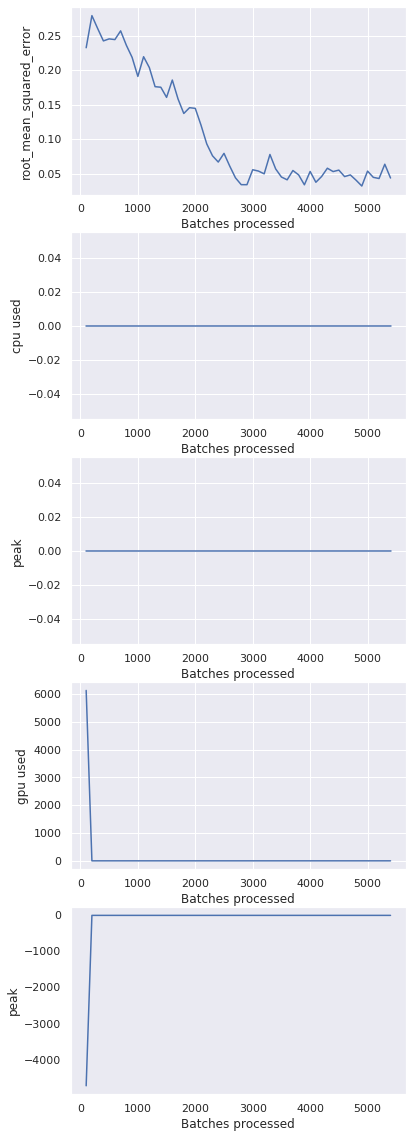

In [38]:
time_series_cv_log = list()
cv_log_cols = ["root_mean_square_error", "period", "learn_rate", "training_time_seconds"]

lr = None
# for i in range(0, len(df_model_by_period["train"])):
    
#     print("\n---------- PERIOD: " + str(i) + " ----------")
    
# get the current time 
now = time.time()

#     # TODO: TEST THE BELOW
#     # if this isn't the first time a model is trained, load it from memory 
#     if i != 0:
#         # load learner
#         lr = lr.load('model-latest')  

# first, create a data bunch for this round of the modeling process        

# below line "hacked" to use dataset as one large one 
# df_train = df_model_by_period["train"]
df_train = pd.concat(df_model_by_period["train"])


df_train[DEP + "_target"] = df_train[DEP]
df_test = df_model_by_period["test"]
df_test[DEP + "_target"] = df_test[DEP]
df_valid = df_model_by_period["valid"]
df_valid[DEP + "_target"] = df_valid[DEP]

data_bunch = make_dataBunch(
    df_train, 
    df_test,
    df_valid,
    FEATURES, 
    DEP + "_target", 
    include_catvars=False, 
    catvars=None, 
    batch_size=BATCH_SIZE
)

# define the model 
if lr is None: 
    lr = tabular_learner(
        data_bunch["databunch"], 
        layers=architectures[MODEL_ARCHITECTURE]["layers"], 
        ps=architectures[MODEL_ARCHITECTURE]["ps"],
        metrics=[root_mean_squared_error], 
        callback_fns=[CSVLogger, PeakMemMetric],
        use_bn=BATCH_NORM,
        wd=WEIGHT_DECAY
    )

#     # automatically find the ideal learning rate 
#     try:
#         learn_rate = find_appropriate_lr(
#             model=lr,
#             plot=True
#         )

#     except:
#         learn_rate = 0.001
#         print("ERROR: cannot determine learning rate.")

learn_rate = 0.001

print("Learning rate: " + str(learn_rate))

# train the model 
lr.fit_one_cycle(
    MAX_EPOCHS, # max epochs
    learn_rate,
    callbacks=[
        SaveModelCallback(
            lr, 
            every='epoch', 
            monitor=['accuracy', 'root_mean_square_error']
        ),
        EarlyStoppingCallback(
            lr,
            monitor='valid_loss', #'valid_loss', 'root_mean_square_error'
            min_delta=0.0001, # 0.0001
            patience=25
        ),
        ShowGraph(
            lr
        )
    ]
)

# loaded learners do not have a recorder
lr.recorder.plot_losses()
lr.recorder.plot_metrics()

# last set of scores for this training cycle 
rmse = lr.recorder.metrics[-1][0].item()

# get the end time 
later = time.time()

# get time time difference in seconds
time_diff = int(later - now)

time_series_cv_log.append(
#     [rmse, i, learn_rate, time_diff]
    [rmse, 0, learn_rate, time_diff]
)

# save learner and export the model weights
lr.save(MODEL_LOCATION)
lr.export(MODEL_LOCATION + '-export.pkl')
    
#     # destroy the learner and clear the mem cache 
#     lr.destroy()
#     torch.cuda.empty_cache() 
        
print("Results from last tra ining set.")
print(lr.show_results())
   
time_series_cv_results_df = pd.DataFrame(
    time_series_cv_log,
    columns=cv_log_cols
)               

In [39]:
# destroy the learner and clear the mem cache
# lr.destroy()
# torch.cuda.empty_cache() 

In [40]:
time_series_cv_results_df
# TODO: add num epochs trained 
# TODO: add total training time for period 

root_mean_square_error  period  learn_rate  training_time_seconds
0                0.043937       0       0.001                   2780

Note that the above training process is specific to a satellite and ground station. In order to report many of the metrics below, we will need to (at a later date) perform the training and testing process over multiple satellite and ground station combinations. 

Now that the model training is complete, load the learner from disk. 

In [41]:
# lr = tabular_learner(
#         data_bunch["databunch"], 
#         layers=architectures[MODEL_ARCHITECTURE]["layers"], 
#         ps=architectures[MODEL_ARCHITECTURE]["ps"],
#         metrics=[root_mean_squared_error], 
#         callback_fns=[CSVLogger, PeakMemMetric],
#         use_bn=BATCH_NORM,
#         wd=WEIGHT_DECAY
#     )

In [42]:
# # load learner
# lr = lr.load('model-latest') 

In [43]:
# show me a summary look at the results 
lr.show_results()

Plot the values on the testing set used for model training. 

In [44]:
# function to predict values using input data from new data

def predict_values(dataframe, learner, dependent, frac=1.0):
    
    """
    Using the passed learner, predicts the appropriate value given the input data 
    and generates errors for analysis. 
    """
    
    # get a sample of the dataset 
    dataframe_pred = dataframe.copy()
    n_obs = int(dataframe_pred.shape[0] * frac)
    idx = random.sample(range(0, dataframe_pred.shape[0]), n_obs)
    dataframe_pred = dataframe_pred.iloc[idx, :]
    
    # get the predictions
    
    # TODO: update this to work with gpu over large samples like the other function 
    predictions = []
    print('Generating predictions and errors...')
    for idx, row in tqdm(dataframe_pred.iterrows(), total=dataframe_pred.shape[0]):        
        predictions.append(learner.predict(row)[1].numpy()[0])
    
    
    dataframe_pred["predicted"] = predictions
    dataframe_pred['error'] = dataframe_pred['predicted'] - dataframe_pred[dependent]
    dataframe_pred['absolute_error'] = np.abs(dataframe_pred['error'])
    dataframe_pred["timestamp"] = dataframe_pred.index
    
    return dataframe_pred
    

Generate a dataframe from the predicted values on the `test` set. 

In [45]:
df_test = predict_values(
    dataframe=data_bunch["test"], # TODO: currently using latest databunch from prev loop
    learner=lr, # TODO: currently using latest learner from prev loop
    dependent=DEP + "_target",
    frac=1.
).sort_index()

Generating predictions and errors...


Plot the predicted (blue) versus the actual (gray) values. 

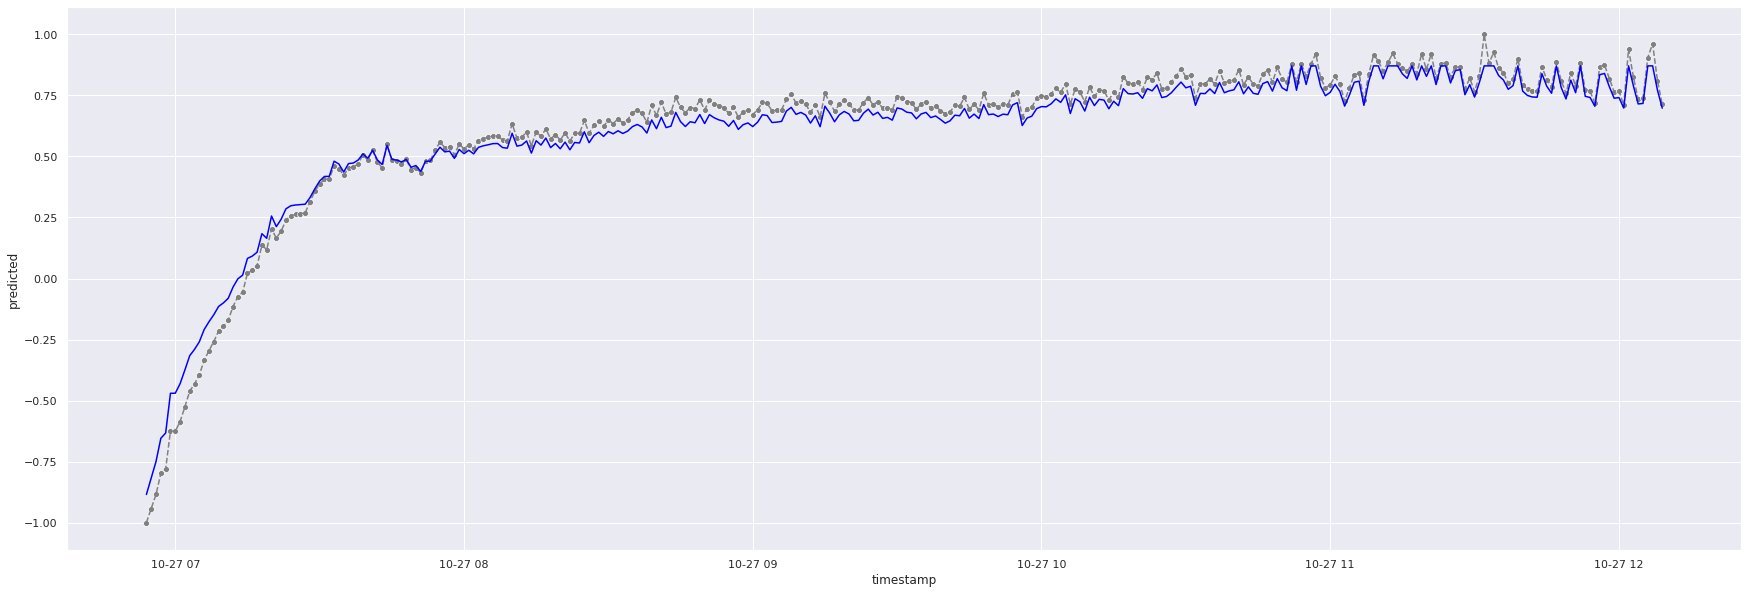

In [46]:
plt.figure(figsize=(30, 10))

ax = sns.lineplot(x=df_test.index, y=DEP + "_target", data=df_test, color="gray")
ax.lines[0].set_linestyle("--")

ax2 = sns.scatterplot(x=df_test.index, y=DEP + "_target",
            data=df_test,
            color="gray")


ax3 = sns.lineplot(x=df_test.index, y="predicted", data=df_test, color="blue")

plt.show()

Plot the absolute error. 

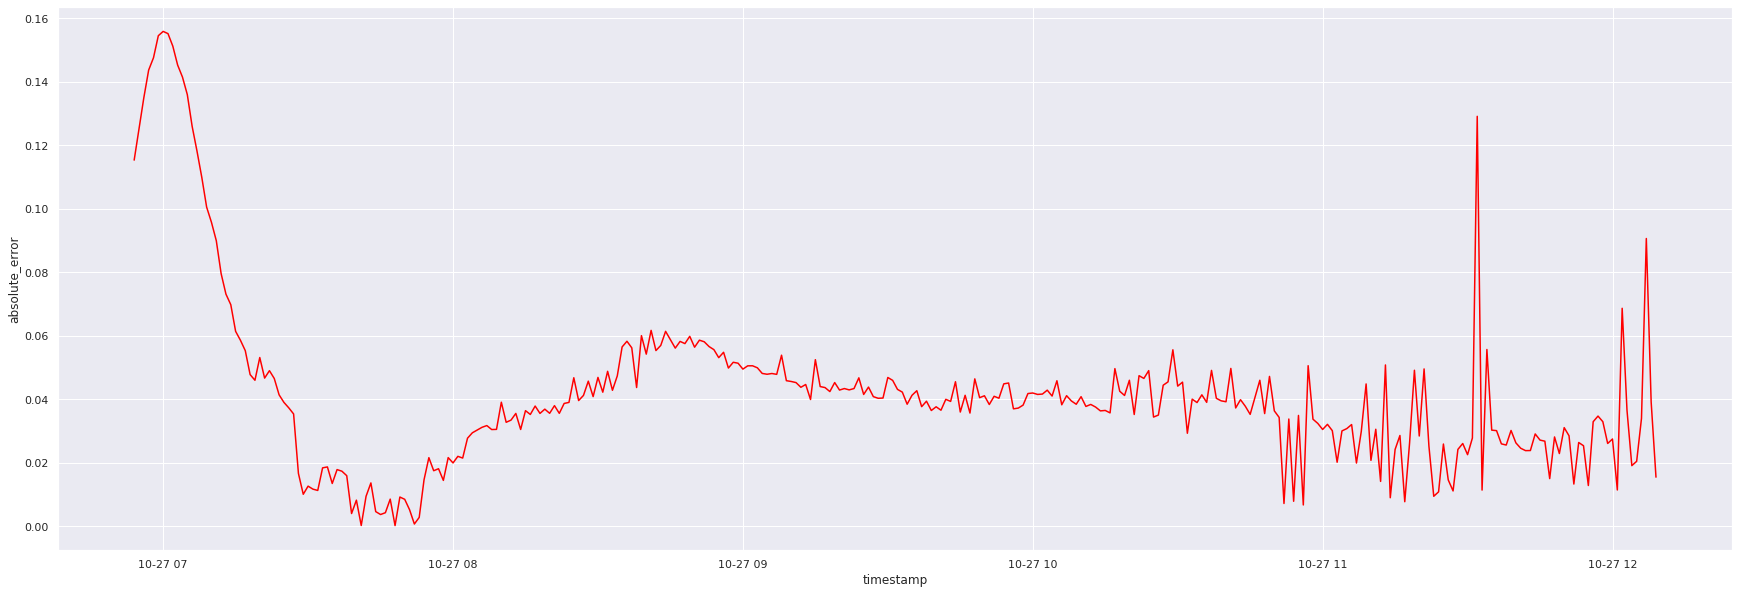

In [47]:
plt.figure(figsize=(30, 10))


ax = sns.lineplot(x=df_test.index, y="absolute_error", data=df_test, color="red")
# ax.lines[0].set_linestyle("--")

# ax2 = sns.scatterplot(x=df_assess_day.index, y="absolute_error",
#             data=df_assess_day,
#             color="darkgray")

plt.show()

## Identify and Classify Tsunami-Related Disturbances

Using the validation data - the day of the earthquake - use the residuals to detect the anomaly. 

This section is a **work in progress**. In order to estimate the model's `accuracy`, `recall`, `precision`, `F-score`, and `coverage`, we need to be able to classify specific time periods as anomalous - in this context, as ionoshperic disturbances related to tsunami waves. 

In [48]:
df_assess = predict_values(
    dataframe=data_bunch["valid"], # TODO: currently using latest databunch from prev loop
    learner=lr, # TODO: currently using latest learner from prev loop
    dependent=DEP + "_target",
    frac=1.
).sort_index()

Generating predictions and errors...


In [49]:
df_assess.sample(frac=1).head()

ahup__G07  ahup__G07_lon  ahup__G07_lat  ahup__G07_h_ipp  \
timestamp                                                                       
2012-10-28 10:11:00   0.832044      -0.498542       0.514934        -0.140836   
2012-10-28 11:47:00   0.740019       0.610579       0.972282         0.018640   
2012-10-28 10:06:00   0.845177      -0.524576       0.488589        -0.546995   
2012-10-28 08:25:00   0.714279      -0.772832      -0.018107        -0.682222   
2012-10-28 10:56:00   0.806686      -0.150537       0.754674        -0.131666   

                     ahup__G07_ele  ahup__G07_azi    sod  ahup__G07_target  \
timestamp                                                                    
2012-10-28 10:11:00       0.034152      -0.931843  36660          0.832044   
2012-10-28 11:47:00      -0.876425      -0.747905  42420          0.740019   
2012-10-28 10:06:00       0.093410      -0.941994  36360          0.845177   
2012-10-28 08:25:00       0.894427       0.328002  30300          0.714279   
2012-10-28 10:56:00      -0.447137      -0.846527  39360          0.806686   

                     predicted     error  absolute_error           timestamp  
timestamp                                                                     
2012-10-28 10:11:00   0.790546 -0.041498        0.041498 2012-10-28 10:11:00  
2012-10-28 11:47:00   0.721837 -0.018182        0.018182 2012-10-28 11:47:00  
2012-10-28 10:06:00   0.800664 -0.044513        0.044513 2012-10-28 10:06:00  
2012-10-28 08:25:00   0.660961 -0.053317        0.053317 2012-10-28 08:25:00  
2012-10-28 10:56:00   0.780531 -0.026155        0.026155 2012-10-28 10:56:00

### Plot Actual and Predicted Values

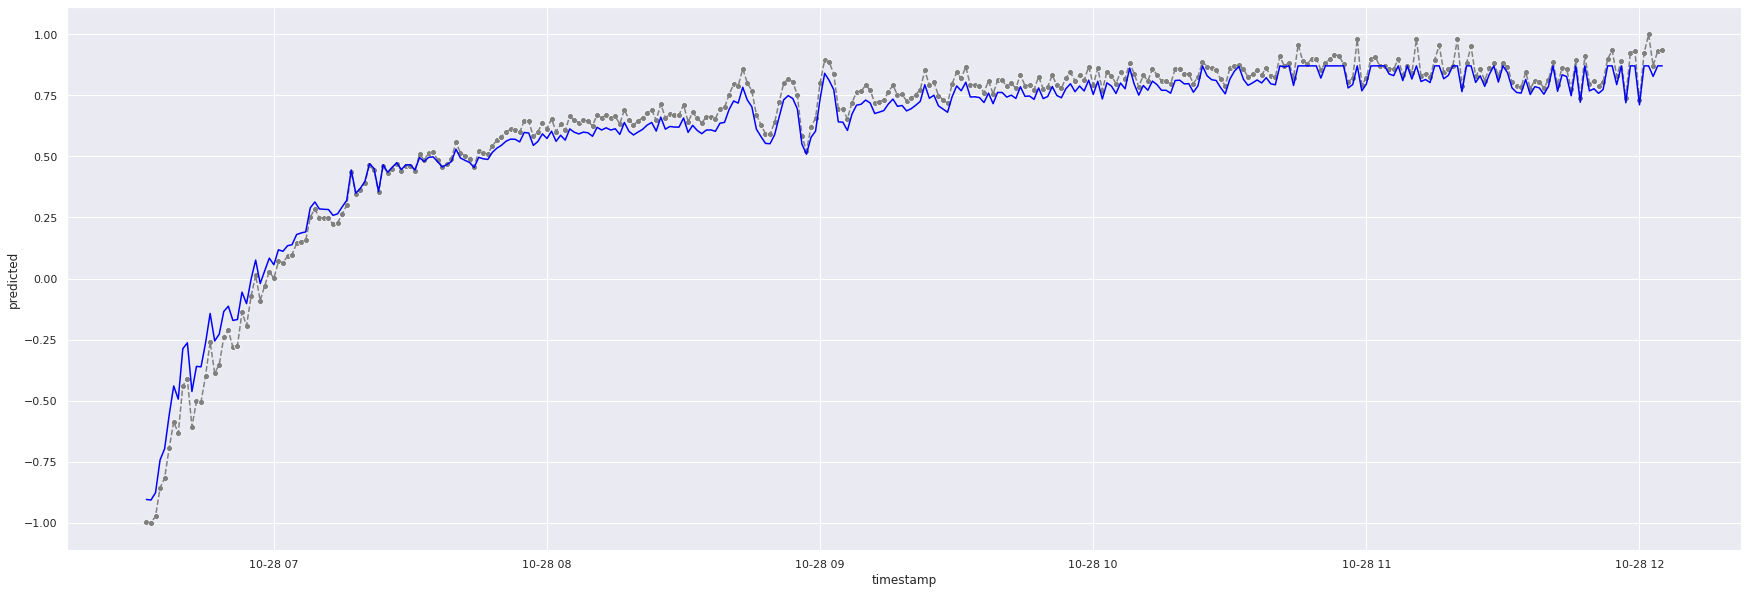

In [50]:
plt.figure(figsize=(30, 10))

ax = sns.lineplot(x=df_assess.index, y=DEP + "_target", data=df_assess, color="gray")
ax.lines[0].set_linestyle("--")

ax2 = sns.scatterplot(x=df_assess.index, y=DEP + "_target",
            data=df_assess,
            color="gray")


ax3 = sns.lineplot(x=df_assess.index, y="predicted", data=df_assess, color="blue")

plt.show()

### Plot the Absolute Error 

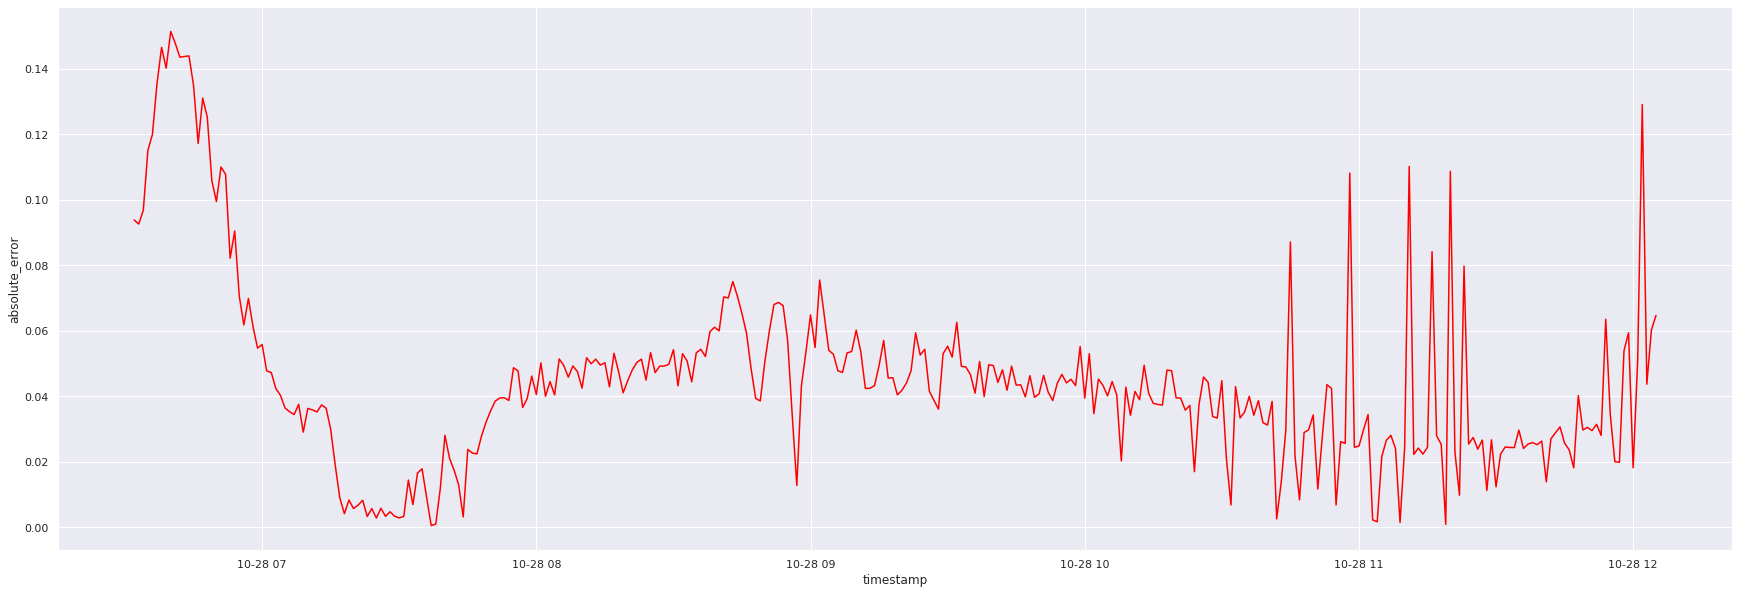

In [51]:
plt.figure(figsize=(30, 10))


ax = sns.lineplot(x=df_assess.index, y="absolute_error", data=df_assess, color="red")
# ax.lines[0].set_linestyle("--")

# ax2 = sns.scatterplot(x=df_assess_day.index, y="absolute_error",
#             data=df_assess_day,
#             color="darkgray")

plt.show()

If we see a spike in the residual values at the approximate time of the tsunami-wave, we can use that information to explore ways of automating the detection of these disturbances. The approach to utilize for this classification is explored in the following sections. 

It should be noted that the ability to detect these disturbances must be thoroughly tested across multiple satellites and ground stations. 

### Classify Time Periods As Anomalous

Model performance will generally always be impacted towards the start of a period (day) due to having less available data (data less than the specified batch size) for making predictions. This impacts model performance (confidence) at the start of any period, and thus confidence in the model will be less at early stages (until about an hour of data is collected). 

Once the event occurs, it seems to represent a large-enough deviation from the previous day(s) (used for model training) to result in elevated absolute errors for each prediction by the model after the change begins to occur in the the TEC variation. We can use this emperical finding to create a method for detection. 

We will not be able to do any better than an on-time detection of the event (meaning, there will be some lag between the start of the event and the detection of the event). We can score the approach and generate metrics (described further below) based on some specified threshold of acceptability of detection, e.g. 5 minutes (or something else). 

In [52]:
# definition of start times for tsunami-wave induced pertubations by satellite
# start time defined by second in day 
sod_annotations = {
    "G04": 31400,
    "G07": 31160,
    "G08": 31900,
    "G10": 29900,
    "G20": 31150
}

Let's create an improved version of an earlier plot showing absolute errors that highlights the period of increased model confidence / performance at the start of the period and also has a vertical line indicating the start time of the pertubation in TEC variation. This plot will also show the time period in which we classify as anomalous. 

In [53]:
sod_annotations

{'G04': 31400, 'G07': 31160, 'G08': 31900, 'G10': 29900, 'G20': 31150}

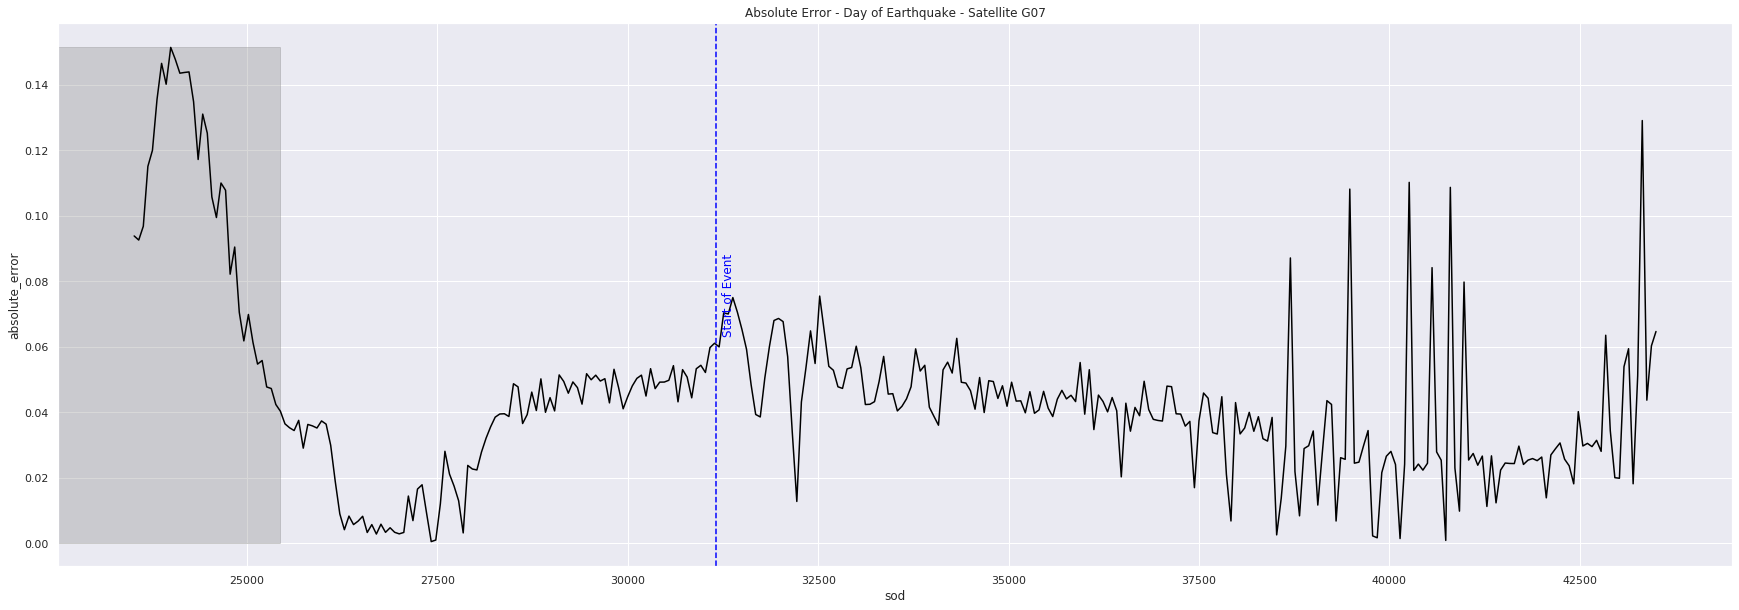

In [54]:
plt.figure(figsize=(30, 10))


ax = sns.lineplot(x=df_assess["sod"], y="absolute_error", data=df_assess, color="black")
ax.axvline(sod_annotations[SAT], color="blue", linestyle="--")
plt.text(sod_annotations[SAT] + 80, np.max(df_assess["absolute_error"].values) / 2, "Start of Event", rotation=90, verticalalignment='center', color="blue")
ax.add_patch(
    patches.Rectangle(
        (0, 0), 
        df_assess.iloc[BATCH_SIZE]["sod"],
        np.max(df_assess["absolute_error"].values),
        color="gray",
        alpha=0.3
    )
)
ax.set_title('Absolute Error - Day of Earthquake - Satellite ' + SAT)

# ax2 = sns.lineplot(x=df_assess["sod"], y="absolute_error", data=df_assess, color="black")

plt.show()

Goal to develop approach of handling residual values for detection. 

In [55]:
# mean of abs errors 
np.mean(df_assess["absolute_error"])

0.0442997864384453

In [56]:
# standard devation
np.std(df_assess["absolute_error"])

0.0283292172740162

#### Distribution of Errors 

A lot of error handling approaches and work assume that the errors have Gaussian distributions. Let's visualize the distribution of values and do a formal test for normality. If we find that the distribution of errors is generally normal, we could use approaches that are suitable for that type of data distribution. If not, we should look at other approaches for handling the model errors. 

/home/vconstan/.conda/envs/tsunami/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



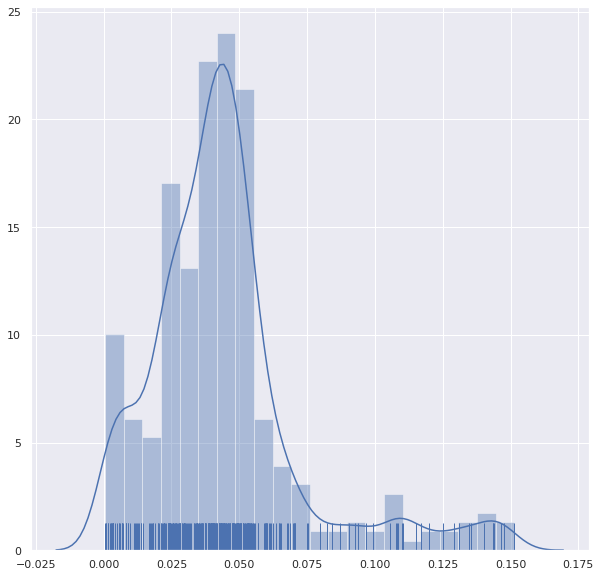

In [57]:
# distribution of the errors
plt.figure(figsize=(10, 10))
sns.distplot(df_assess["absolute_error"].values, kde=True, rug=True);
plt.show()

Let's plot a QQ plot. This will provide a visual indication as to the normality of the data. If the points closely follow the diagonal line, then they closely fit the pattern we would expect from a Gaussian distribution. 

In [58]:
qq = stats.probplot(df_assess["absolute_error"].values, dist='lognorm', sparams=(1))
x = np.array([qq[0][0][0], qq[0][0][-1]])

fig = go.Figure()
fig.add_scatter(x=qq[0][0], y=qq[0][1], mode='markers')
fig.add_scatter(x=x, y=qq[1][1] + qq[1][0]*x, mode='lines')
fig.layout.update(showlegend=False)
fig.show()

#### Normality Tests

In [59]:
# Shapiro normality test
stat, p = stats.shapiro(df_assess["absolute_error"].values)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.861, p=0.000
Sample does not look Gaussian (reject H0)


In [60]:
# D’Agostino’s K^2  normality test
stat, p = stats.normaltest(df_assess["absolute_error"].values)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=108.799, p=0.000
Sample does not look Gaussian (reject H0)


In [61]:
# Anderson-Darling normality test
result = stats.anderson(df_assess["absolute_error"].values)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 12.431
15.000: 0.569, data does not look normal (reject H0)
10.000: 0.648, data does not look normal (reject H0)
5.000: 0.778, data does not look normal (reject H0)
2.500: 0.907, data does not look normal (reject H0)
1.000: 1.079, data does not look normal (reject H0)


#### Using a Time-based Distancing Approach 

For each observation, get the distances from each of the previous observations from _T_ steps prior (so the difference / distance in absolute errors). Then, log transform these distances to prioritize local anomalies (inspired from approach by Ian Colwell for MSL anomaly detection). 

In [77]:
# number of previous time steps T to consider
DIST_WINDOW = 30

In [78]:
def calc_dist_measure(dataframe: pd.DataFrame, window_size: int = 10, show_dist_plot: bool = False) -> pd.DataFrame:

    """
    Calculates the distance 
    """
    
    # create a dataframe for the errors 
    df_error = dataframe[["sod", "absolute_error"]].iloc[window_size:].reset_index().sort_values(by="sod")
    
    # create a dataframe to store distances between absolute errors
    # more specifically, to store the mean distance from an observation 
    # to its previous N neighbors 
    df_error_dist = pd.DataFrame(list(), index=df_error["sod"], columns=df_error["sod"])
    for idx, row in tqdm(df_error.iterrows(), total=df_error.shape[0]):
    
        # get the current absolute error 
        abs_error = row["absolute_error"]

        # get the absolute error values for the previous N values
        prev = dataframe.iloc[idx:idx+window_size] # note indexing to account for window size 
        
        # get the distances 
        for idx2, row2 in prev.iterrows():
            
            # TODO: could apply a weighted average here 
            
            dist = spatial.distance.euclidean(abs_error, row2["absolute_error"])    
            # note log transformed values here :
            df_error_dist.loc[row["sod"], row2["sod"]] = np.log(dist + 1.)
            df_error_dist.loc[row2["sod"], row["sod"]] = np.log(dist + 1.)  
            
    # optionally show a plot 
    if show_dist_plot is True:
        plt.figure(figsize=(15, 10))
        ax = sns.heatmap(df_error_dist.sort_index().sort_index(axis=1).fillna(0.))
        plt.show()
        
    # use that distance matrix to get the min/max/mean distance in the last window  
    # we only want to use observations with a full window size 
    counts = df_error_dist.count().reset_index().rename(columns={0: "counts"})
    full_sods = counts[counts["counts"] >= window_size]["sod"]
    
    df_error_dist_flat = df_error_dist.loc[full_sods].min(axis=1)
    df_error_dist_flat = df_error_dist_flat.reset_index().rename(columns={0: "dist_measure"})

    return df_error_dist_flat

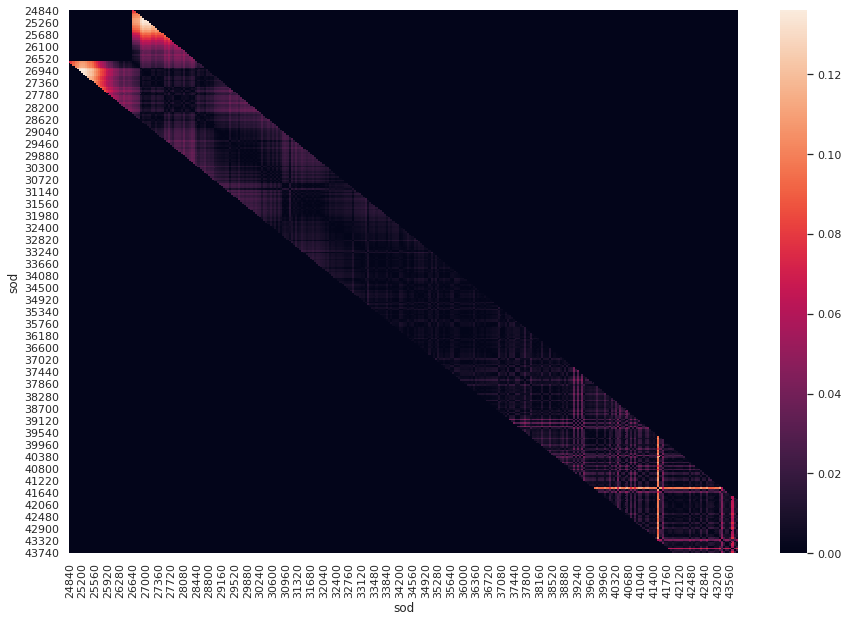

In [79]:
df_test_dist_calc = calc_dist_measure(
    df_test,
    window_size=DIST_WINDOW,
    show_dist_plot=True
)

In [80]:
df_test_dist_calc["dist_measure"].shape

(287,)

In [81]:
df_test.shape

(316, 13)

In [82]:
def get_val(dataframe, row):
    try:
        return dataframe[dataframe["sod"] == row]["dist_measure"].values[0]
    except:
        return 0.

In [83]:
df_test["dist_measure"] = [0.] * df_test.shape[0]
df_test["dist_measure"] = df_test["sod"].apply(
    lambda x: get_val(df_test_dist_calc, x)
)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_test["dist_measure_scaled"] = scaler.fit_transform([df_test["dist_measure"].values]).T

# df_test["dist_measure"]

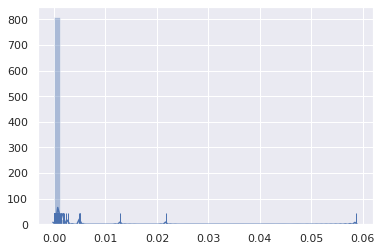

In [84]:
sns.distplot(df_test["dist_measure"].values, kde=True, rug=True);

In [85]:
df_test["dist_measure"].describe()

count    316.000000
mean       0.000596
std        0.003612
min        0.000000
25%        0.000053
50%        0.000143
75%        0.000340
max        0.058704
Name: dist_measure, dtype: float64

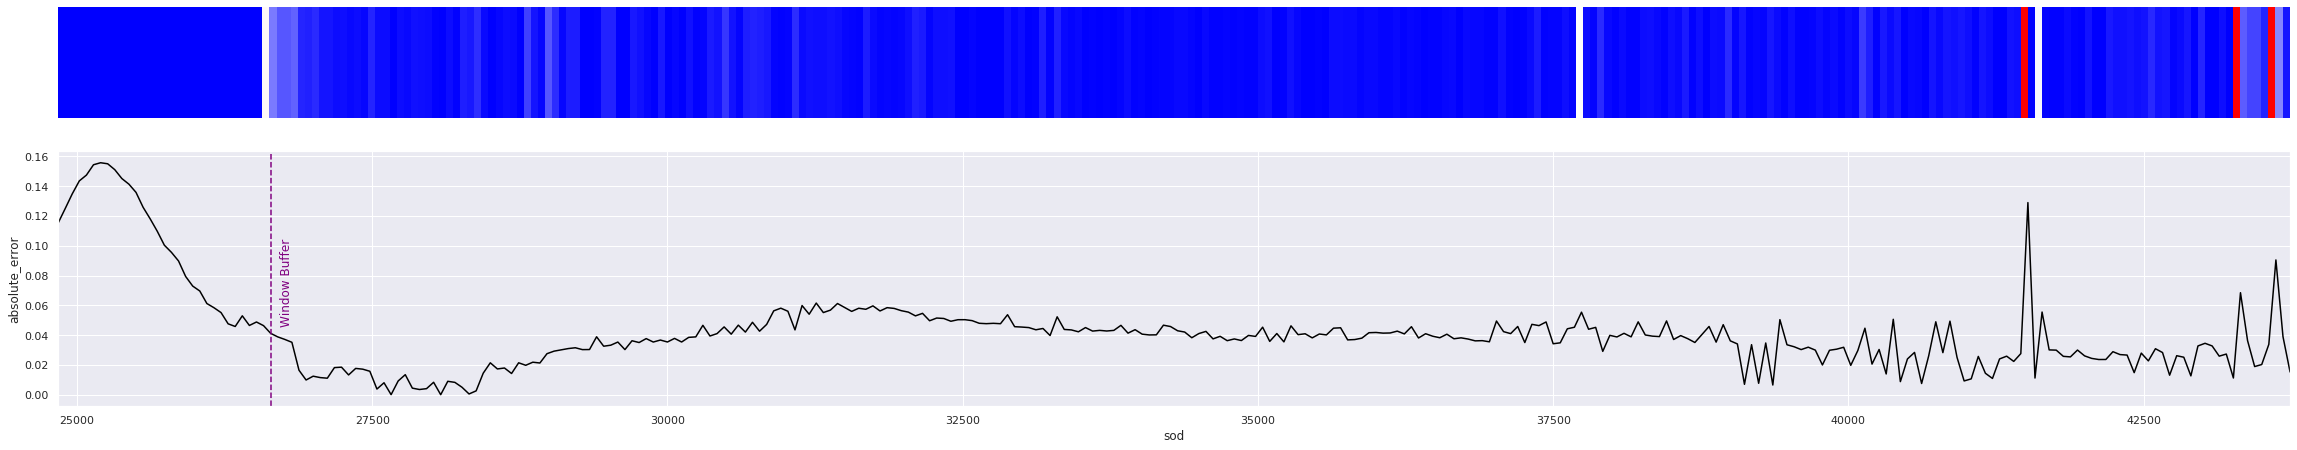

In [86]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(40, 10))
grid = plt.GridSpec(4, 8, wspace=0.4, hspace=0.3)

plt.subplot(grid[1:3, 0:8])

# ax1 = plt.figure(figsize=(30, 10))
ax1 = sns.lineplot(x=df_test["sod"], y="absolute_error", data=df_test, color="black")
ax1.margins(x=0)

# add a vertical line to indicate when a full window of distance values is available 
ax1.axvline(df_test.iloc[DIST_WINDOW]["sod"], color="purple", linestyle="--")
ax1.text(df_test.iloc[DIST_WINDOW]["sod"] + 80, np.max(df_assess["absolute_error"].values) / 2, "Window Buffer", rotation=90, verticalalignment='center', color="purple")

plt.subplot(grid[0, 0:8])
ax2 = sns.heatmap(
    [df_test["dist_measure"].values],
    cmap="bwr",
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    vmin=0, 
    vmax=0.01
)


plt.show()

In [87]:
df_assess_dist_calc = calc_dist_measure(
    df_assess,
    window_size=DIST_WINDOW,
    show_dist_plot=False
)

In [88]:
df_assess["dist_measure"] = [0.] * df_assess.shape[0]
df_assess["dist_measure"] = df_assess["sod"].apply(
    lambda x: get_val(df_assess_dist_calc, x)
)

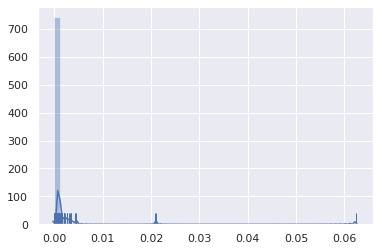

In [89]:
sns.distplot(df_assess["dist_measure"].values, kde=True, rug=True);

In [90]:
df_assess["dist_measure"].describe()

count    334.000000
mean       0.000700
std        0.003802
min        0.000000
25%        0.000048
50%        0.000154
75%        0.000433
max        0.062387
Name: dist_measure, dtype: float64

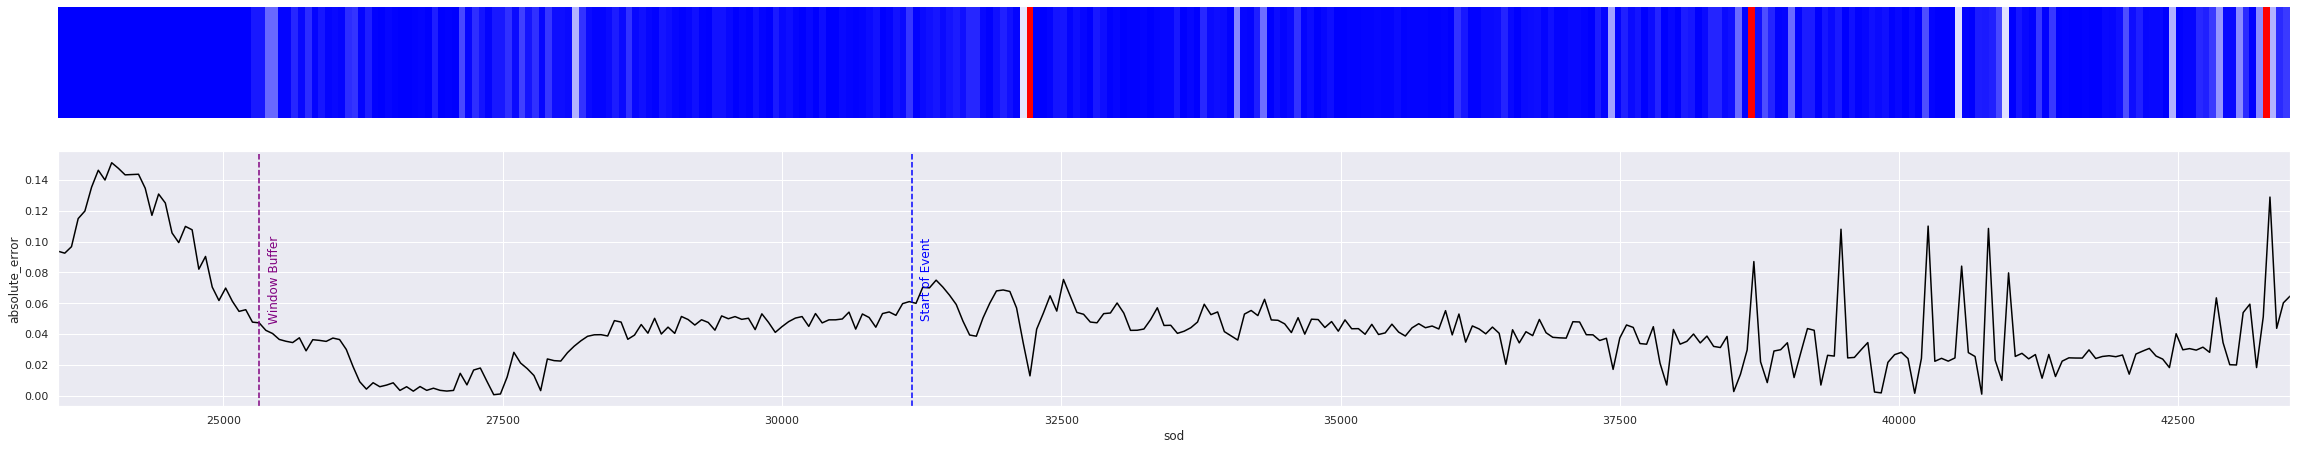

In [91]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(40, 10))
grid = plt.GridSpec(4, 8, wspace=0.4, hspace=0.3)

plt.subplot(grid[1:3, 0:8])

# ax1 = plt.figure(figsize=(30, 10))
ax1 = sns.lineplot(x=df_assess["sod"], y="absolute_error", data=df_assess, color="black")
ax1.margins(x=0)

# add a vertical line to indicate the event 
ax1.axvline(sod_annotations[SAT], color="blue", linestyle="--")
ax1.text(sod_annotations[SAT] + 80, np.max(df_assess["absolute_error"].values) / 2, "Start of Event", rotation=90, verticalalignment='center', color="blue")

# add a vertical line to indicate when a full window of distance values is available 
ax1.axvline(df_assess.iloc[DIST_WINDOW]["sod"], color="purple", linestyle="--")
ax1.text(df_assess.iloc[DIST_WINDOW]["sod"] + 80, np.max(df_assess["absolute_error"].values) / 2, "Window Buffer", rotation=90, verticalalignment='center', color="purple")


plt.subplot(grid[0, 0:8])
ax2 = sns.heatmap(
    [df_assess["dist_measure"].values],
    cmap="bwr",
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    vmin=0, 
    vmax=0.01
)

plt.show()

## Assess Model and Approach to Classification

We need to report the following metrics: 

- **Root Mean Square Error**: measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed
- **Accuracy**: the number of correct classifications over the number of observations
- **Recall**: fraction of true events that were detected
- **Precision**: fraction of detections reported  by the model that are correct
- **F-Score**: the harmonic mean of the precision and recall, `2pr / (p + r)`
- **Coverage**: fraction of examples for which the system is able to produce a confident classification